# Predicting Particulate Matter (PM2.5) Concentrations in the Air of China

## Exploring Beijing Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Dara preprocessing
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Import train_test_split

# Pretty display for notebooks
%matplotlib inline

import os
print(os.listdir("../China/China_dataset"))

# Load Beijing dataset
dataset_Beijing = pd.read_csv('../China/China_dataset/Beijing.csv', parse_dates={'date' : ['year', 'month', 'day']})

display(dataset_Beijing.head(n=3))
display(dataset_Beijing.info())

dataset_Beijing['year'] = dataset_Beijing['date'].dt.year   
dataset_Beijing['month'] = dataset_Beijing['date'].dt.month
dataset_Beijing['day'] = dataset_Beijing['date'].dt.strftime('%w').astype(int)
# day_type: 1 if the day weekend, 0 if the day weekday
dataset_Beijing['day_Type'] = dataset_Beijing['day'].apply(lambda x: 'Weekends' if x >= 5 else 'Weekdays').astype('category')

dataset_Beijing = dataset_Beijing.drop('date', axis=1)

# Success - Display the first five records
display(dataset_Beijing.head(n=3))
display(dataset_Beijing.info())

# Total number of records
n_records = len(dataset_Beijing["PM_US Post"])

# Print the results
print("Total number of records: {}".format(n_records))

['Beijing.csv', 'Chengdu.csv', 'Guangzhou.csv', 'Shanghai.csv', 'Shenyang.csv']


,date,No,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,new_wind
0,2010-01-01,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0,1.79
1,2010-01-01,2,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0,3.13
2,2010-01-01,3,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0,1.79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
date               52584 non-null datetime64[ns]
No                 52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
new_wind           52579 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(3), object(1)
memory usage: 6.8+ MB


None

,No,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,new_wind,year,month,day,day_Type
0,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0,1.79,2010,1,5,Weekends
1,2,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0,3.13,2010,1,5,Weekends
2,3,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0,1.79,2010,1,5,Weekends


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 20 columns):
No                 52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
new_wind           52579 non-null float64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
day_Type           52584 non-null category
dtypes: category(1), float64(12), int64(6), object(1)
memory us

None

Total number of records: 52584


## Assessing Beijing Data

- Precipitation, Iprec columns have zeros values --> it seems fine
- Drop columns: row, PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan
- Convert Season to categorical 
- Year ? 
- Fix Hour values
- Fix Month values
- Remove records before 2013
- Add a city column
- Fix outliers in columns: PM_US Post, HUMI, TEMP, Iws, DEWP, precipitation, Iprec
- Remove missing values
- Convert Numerical to categorical data
- Drop Iprec: Cumulated precipitation (mm)
- Fix IWS (recalculate the original values)

## Cleaning Beijing Data

In [193]:
# First make copies for cleaning
dataset_Beijing_clean = dataset_Beijing.copy()

In [194]:
#Drop columns: row, PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan, precipitation, Iprec (Iprec: Cumulated precipitation (mm)), Iws (Cumulated wind speed)
Unneeded_Columns = ['No', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'Iprec', 'Iws']
dataset_Beijing_clean = dataset_Beijing_clean.drop(Unneeded_Columns, axis = 1)
display(dataset_Beijing_clean.head(n=5))
len(dataset_Beijing_clean)

,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
0,0,4,NaN,-21.0,43.0,1021.0,-11.0,NW,0.0,1.79,2010,1,5,Weekends
1,1,4,NaN,-21.0,47.0,1020.0,-12.0,NW,0.0,3.13,2010,1,5,Weekends
2,2,4,NaN,-21.0,43.0,1019.0,-11.0,NW,0.0,1.79,2010,1,5,Weekends
3,3,4,NaN,-21.0,55.0,1019.0,-14.0,NW,0.0,3.13,2010,1,5,Weekends
4,4,4,NaN,-20.0,51.0,1018.0,-12.0,NW,0.0,3.13,2010,1,5,Weekends


52584

In [195]:
# Remove records before 2013
dataset_Beijing_clean = dataset_Beijing_clean.drop(dataset_Beijing_clean[dataset_Beijing_clean.year < 2013].index)

print("Total number of records after removing years before 2013: ", len(dataset_Beijing_clean))


print('The statistical summary of air quality data in Beijing')
display(np.round(dataset_Beijing_clean.describe(), 3))

print('The information summary of air quality data in Beijing')
display(dataset_Beijing_clean.info())

Total number of records after removing years before 2013:  26280
The statistical summary of air quality data in Beijing


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,year,month,day
count,26280.000,26280.000,25970.000,26275.000,25941.000,25941.000,26275.00,25796.000,26275.000,26280.000,26280.000,26280.000
mean,11.500,2.490,94.095,2.248,53.608,1016.329,13.12,38.815,2.798,2014.000,6.526,3.000
std,6.922,1.117,93.807,13.897,25.857,10.246,11.76,6226.148,2.222,0.817,3.448,1.998
min,0.000,1.000,1.000,-40.000,2.000,991.000,-17.00,0.000,0.450,2013.000,1.000,0.000
25%,5.750,1.000,27.000,-9.000,31.000,1008.000,3.00,0.000,0.890,2013.000,4.000,1.000
50%,11.500,2.000,66.000,3.000,54.000,1016.000,14.00,0.000,1.790,2014.000,7.000,3.000
75%,17.250,3.000,126.000,15.000,77.000,1025.000,23.00,0.000,4.020,2015.000,10.000,5.000
max,23.000,4.000,886.000,27.000,100.000,1046.000,42.00,999990.000,20.120,2015.000,12.000,6.000


The information summary of air quality data in Beijing
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26280 entries, 26304 to 52583
Data columns (total 14 columns):
hour             26280 non-null int64
season           26280 non-null int64
PM_US Post       25970 non-null float64
DEWP             26275 non-null float64
HUMI             25941 non-null float64
PRES             25941 non-null float64
TEMP             26275 non-null float64
cbwd             26275 non-null object
precipitation    25796 non-null float64
new_wind         26275 non-null float64
year             26280 non-null int64
month            26280 non-null int64
day              26280 non-null int64
day_Type         26280 non-null category
dtypes: category(1), float64(7), int64(5), object(1)
memory usage: 2.8+ MB


None

In [196]:
(dataset_Beijing_clean[dataset_Beijing_clean['PM_US Post'] > 800])


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
26582,14,4,802.0,-7.0,63.0,1021.0,-1.0,SE,0.0,1.79,2013,1,6,Weekends
26583,15,4,845.0,-7.0,63.0,1021.0,-1.0,SE,0.0,1.79,2013,1,6,Weekends
26584,16,4,810.0,-7.0,68.0,1021.0,-2.0,SE,0.0,1.79,2013,1,6,Weekends
26586,18,4,824.0,-8.0,85.0,1021.0,-6.0,SE,0.0,1.79,2013,1,6,Weekends
26587,19,4,886.0,-8.0,92.0,1022.0,-7.0,cv,0.0,0.89,2013,1,6,Weekends
26588,20,4,852.0,-8.0,92.0,1023.0,-7.0,cv,0.0,0.45,2013,1,6,Weekends
26589,21,4,858.0,-9.0,92.0,1023.0,-8.0,NE,0.0,0.89,2013,1,6,Weekends
26590,22,4,805.0,-10.0,92.0,1024.0,-9.0,cv,0.0,0.89,2013,1,6,Weekends


In [197]:
dataset_Beijing_clean = dataset_Beijing_clean[pd.notnull(dataset_Beijing_clean['PM_US Post'])]
print("Total number of records after removing missing values in PM 2.5: ", len(dataset_Beijing_clean))


Total number of records after removing missing values in PM 2.5:  25970


In [198]:
# Convert Season to categorical
dataset_Beijing_clean.season = dataset_Beijing_clean.season.astype('category')
dataset_Beijing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25970 entries, 26304 to 52583
Data columns (total 14 columns):
hour             25970 non-null int64
season           25970 non-null category
PM_US Post       25970 non-null float64
DEWP             25965 non-null float64
HUMI             25631 non-null float64
PRES             25631 non-null float64
TEMP             25965 non-null float64
cbwd             25965 non-null object
precipitation    25497 non-null float64
new_wind         25965 non-null float64
year             25970 non-null int64
month            25970 non-null int64
day              25970 non-null int64
day_Type         25970 non-null category
dtypes: category(2), float64(7), int64(4), object(1)
memory usage: 2.6+ MB


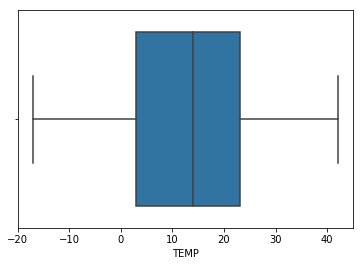

In [199]:
# Fix outliers in columns: HUMI, TEMP, Iws and DEWP
# In statistics, an outlier is an observation point that is distant from other observations.
# Discover outliers with visualization tools
import seaborn as sns
sns.boxplot(x=dataset_Beijing_clean['TEMP'])


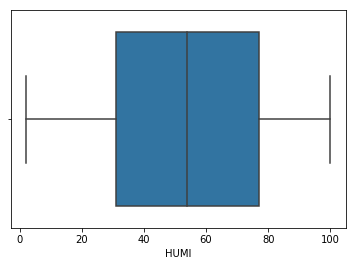

In [200]:
sns.boxplot(x=dataset_Beijing_clean['HUMI'])


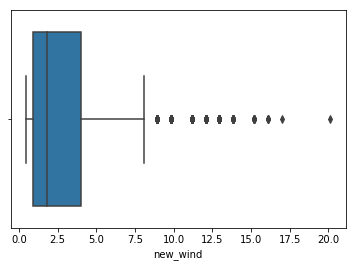

In [201]:
sns.boxplot(x=dataset_Beijing_clean['new_wind'])


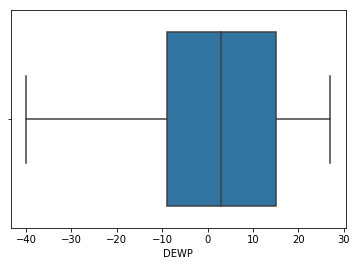

In [202]:
sns.boxplot(x=dataset_Beijing_clean['DEWP'])

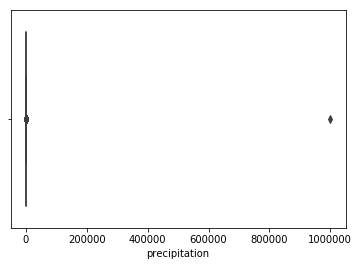

In [203]:
sns.boxplot(x=dataset_Beijing_clean['precipitation'])

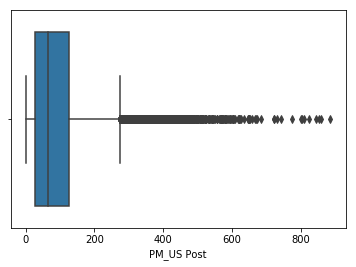

In [204]:
sns.boxplot(x=dataset_Beijing_clean['PM_US Post'])

In [205]:
Q1 = dataset_Beijing_clean.quantile(0.25)
Q3 = dataset_Beijing_clean.quantile(0.75)
IQR = Q3 - Q1
L = IQR + Q3

print(IQR)
print('--')
print(L)

hour             13.00
PM_US Post       99.00
DEWP             24.00
HUMI             46.00
PRES             17.00
TEMP             20.00
precipitation     0.00
new_wind          3.13
year              2.00
month             6.00
day               4.00
dtype: float64
--
hour               31.00
PM_US Post        225.00
DEWP               39.00
HUMI              123.00
PRES             1042.00
TEMP               43.00
precipitation       0.00
new_wind            7.15
year             2017.00
month              16.00
day                 9.00
dtype: float64


In [206]:
import numpy as np

def outliers_iqr(dataset ,ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    print("> upper_bound (",upper_bound , ") = ", len(dataset[dataset['PM_US Post'] > upper_bound]))
    print("< lower_bound (",lower_bound , ") = ", len(dataset[dataset['PM_US Post'] < lower_bound]))
    
    dataset = dataset.drop(dataset[dataset['PM_US Post'] > upper_bound].index)
    dataset = dataset.drop(dataset[dataset['PM_US Post'] < lower_bound].index)
    return dataset

In [207]:
#dataset_Beijing_clean = outliers_iqr(dataset_Beijing_clean , dataset_Beijing_clean['PM_US Post'])

In [208]:
# Check tempreture 
(dataset_Beijing_clean[dataset_Beijing_clean.TEMP < -15])


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
26378,2,4,58.0,-22.0,59.0,1038.0,-16.0,NW,0.0,3.13,2013,1,5,Weekends
26379,3,4,56.0,-22.0,65.0,1038.0,-17.0,NW,0.0,1.79,2013,1,5,Weekends
26382,6,4,37.0,-23.0,54.0,1036.0,-16.0,NW,0.0,1.79,2013,1,5,Weekends
26384,8,4,41.0,-22.0,59.0,1035.0,-16.0,NW,0.0,1.79,2013,1,5,Weekends


In [209]:
# Check wind speed 
(dataset_Beijing_clean[dataset_Beijing_clean.new_wind > 8])


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
26315,11,4,10.0,-22.0,21.0,1024.0,-3.0,NW,0.0,8.94,2013,1,2,Weekdays
26316,12,4,16.0,-23.0,19.0,1023.0,-3.0,NW,0.0,8.05,2013,1,2,Weekdays
26317,13,4,17.0,-23.0,21.0,1023.0,-4.0,NW,0.0,8.05,2013,1,2,Weekdays
26318,14,4,15.0,-23.0,21.0,1024.0,-4.0,NW,0.0,8.05,2013,1,2,Weekdays
26319,15,4,13.0,-25.0,19.0,1025.0,-5.0,NW,0.0,8.94,2013,1,2,Weekdays
26320,16,4,16.0,-25.0,20.0,1026.0,-6.0,NW,0.0,8.05,2013,1,2,Weekdays
26321,17,4,15.0,-25.0,22.0,1027.0,-7.0,NW,0.0,8.05,2013,1,2,Weekdays
26322,18,4,20.0,-27.0,20.0,1028.0,-8.0,NW,0.0,8.05,2013,1,2,Weekdays
26323,19,4,17.0,-26.0,23.0,1029.0,-9.0,NW,0.0,8.94,2013,1,2,Weekdays
26325,21,4,19.0,-27.0,23.0,1031.0,-10.0,NW,0.0,8.05,2013,1,2,Weekdays


In [210]:
(dataset_Beijing_clean[dataset_Beijing_clean['PM_US Post'] > 274.5])


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
26443,19,4,335.0,-16.0,33.0,1026.0,-2.0,SE,0.0,3.13,2013,1,0,Weekdays
26444,20,4,392.0,-16.0,45.0,1025.0,-6.0,cv,0.0,0.45,2013,1,0,Weekdays
26445,21,4,413.0,-15.0,52.0,1026.0,-7.0,NE,0.0,0.89,2013,1,0,Weekdays
26446,22,4,339.0,-14.0,67.0,1026.0,-9.0,cv,0.0,0.89,2013,1,0,Weekdays
26447,23,4,285.0,-14.0,72.0,1026.0,-10.0,SE,0.0,0.89,2013,1,0,Weekdays
26470,22,4,299.0,-14.0,57.0,1027.0,-7.0,cv,0.0,0.45,2013,1,1,Weekdays
26471,23,4,333.0,-13.0,67.0,1027.0,-8.0,cv,0.0,0.45,2013,1,1,Weekdays
26472,0,4,357.0,-14.0,72.0,1028.0,-10.0,NW,0.0,1.79,2013,1,2,Weekdays
26473,1,4,390.0,-14.0,72.0,1028.0,-10.0,NE,0.0,0.89,2013,1,2,Weekdays
26474,2,4,326.0,-13.0,67.0,1029.0,-8.0,NE,0.0,1.79,2013,1,2,Weekdays


In [211]:
(dataset_Beijing_clean[dataset_Beijing_clean['precipitation'] > 50])


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type
51277,13,3,16.0,-1.0,NaN,NaN,4.0,NE,999990.0,4.92,2015,11,6,Weekends


In [212]:
# Removing Iws Outliers (maximum should be 33 m/s)
#dataset_Beijing_clean = dataset_Beijing_clean.drop(dataset_Beijing_clean[dataset_Beijing_clean.new_wind > 180].index)


In [213]:
# Removing PM_US Post Outliers 
#dataset_Beijing_clean = dataset_Beijing_clean.drop(dataset_Beijing_clean[dataset_Beijing_clean['PM_US Post'] > 225].index)


In [214]:
# Removing PM_US Post Outliers 
dataset_Beijing_clean = dataset_Beijing_clean.drop(dataset_Beijing_clean[dataset_Beijing_clean['precipitation'] > 50].index)


In [215]:
print("dataset_Beijing_clean lenght after removing outliers: ", len(dataset_Beijing_clean))
dataset_Beijing_clean.describe()

dataset_Beijing_clean lenght after removing outliers:  25969


,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,year,month,day
count,25969.000000,25969.000000,25964.000000,25631.000000,25631.000000,25964.000000,25496.000000,25964.000000,25969.000000,25969.000000,25969.000000
mean,11.494628,94.097693,2.273802,53.678241,1016.322832,13.122015,0.050439,2.789271,2013.998152,6.515538,2.993069
std,6.931197,93.807108,13.900916,25.845987,10.240590,11.762589,0.591564,2.212993,0.816400,3.444347,1.996153
min,0.000000,1.000000,-40.000000,2.000000,991.000000,-17.000000,0.000000,0.450000,2013.000000,1.000000,0.000000
25%,5.000000,27.000000,-9.000000,31.000000,1008.000000,3.000000,0.000000,0.890000,2013.000000,4.000000,1.000000
50%,11.000000,66.000000,3.000000,54.000000,1016.000000,14.000000,0.000000,1.790000,2014.000000,7.000000,3.000000
75%,18.000000,126.000000,15.000000,77.000000,1025.000000,23.000000,0.000000,4.020000,2015.000000,10.000000,5.000000
max,23.000000,886.000000,27.000000,100.000000,1046.000000,42.000000,30.400000,20.120000,2015.000000,12.000000,6.000000


In [216]:
# drop rows with missing values
dataset_Beijing_clean = dataset_Beijing_clean.dropna(axis=0, how="any")
print("dataset_Beijing_clean lenght after removing missing values: ", len(dataset_Beijing_clean))


dataset_Beijing_clean lenght after removing missing values:  25162


In [217]:
# Convert month, day and hour Features to Cyclical Features
dataset_Beijing_clean['hour_sin'] = np.sin(dataset_Beijing_clean.hour*(2.*np.pi/24))
dataset_Beijing_clean['hour_cos'] = np.cos(dataset_Beijing_clean.hour*(2.*np.pi/24))
dataset_Beijing_clean['month_sin'] = np.sin((dataset_Beijing_clean.month-1)*(2.*np.pi/12))
dataset_Beijing_clean['month_cos'] = np.cos((dataset_Beijing_clean.month-1)*(2.*np.pi/12))
dataset_Beijing_clean['day_sin'] = np.sin(dataset_Beijing_clean.day*(2.*np.pi/7))
dataset_Beijing_clean['day_cos'] = np.cos(dataset_Beijing_clean.day*(2.*np.pi/7))
# Drop the original features : season, month, day and hour 
#Unneeded_Columns = ['month', 'hour', 'day']
#dataset_Beijing_clean = dataset_Beijing_clean.drop(Unneeded_Columns, axis = 1)
display(dataset_Beijing_clean.head(n=1))


,hour,season,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,precipitation,new_wind,year,month,day,day_Type,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
26304,0,4,31.0,-10.0,67.0,1018.0,-5.0,NW,0.0,4.02,2013,1,2,Weekdays,0.0,1.0,0.0,1.0,0.974928,-0.222521


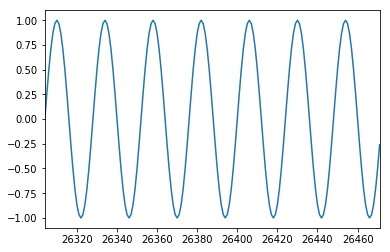

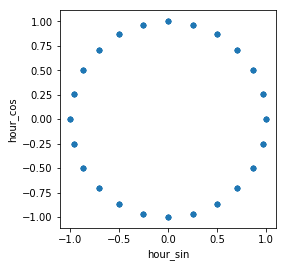

In [218]:
sample = dataset_Beijing_clean[:168]
ax = sample['hour_sin'].plot()
ax = sample.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

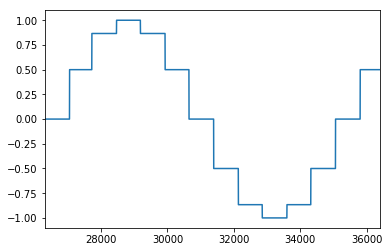

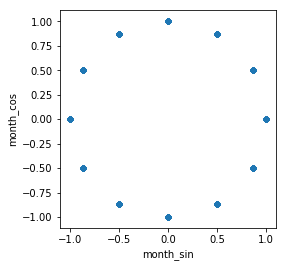

In [219]:
sample = dataset_Beijing_clean[:10000]
ax = sample['month_sin'].plot()
ax = sample.plot.scatter('month_sin', 'month_cos').set_aspect('equal')

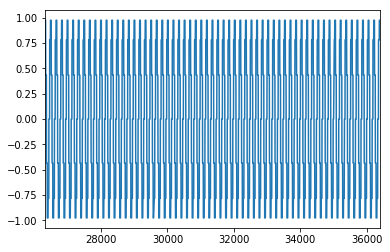

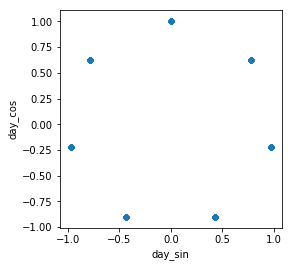

In [220]:
sample = dataset_Beijing_clean[:10000]
ax = sample['day_sin'].plot()
ax = sample.plot.scatter('day_sin', 'day_cos').set_aspect('equal')

In [221]:
# One-hot encode the data using pandas.get_dummies() to convert the non-numeric feature to numeric feature
#dataset_Beijing_clean.month = dataset_Beijing_clean.month.astype('category')
dataset_Beijing_clean = pd.get_dummies(dataset_Beijing_clean)


In [222]:
dataset_Beijing_clean['cbwd_SW'] = 0
dataset_Beijing_clean['cbwd_SW'] = dataset_Beijing_clean['cbwd_SW'].astype(np.uint8)

In [223]:
# Rename day type columns 
dataset_Beijing_clean.rename(columns={"day_Type_Weekdays": "Weekdays", "day_Type_Weekends": "Weekends"}, inplace=True)


In [224]:
dataset_Beijing_clean.head()

,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,year,month,...,season_2,season_3,season_4,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,Weekdays,Weekends,cbwd_SW
26304,0,31.0,-10.0,67.0,1018.0,-5.0,0.0,4.02,2013,1,...,0,0,1,0,1,0,0,1,0,0
26305,1,32.0,-11.0,73.0,1017.0,-7.0,0.0,4.02,2013,1,...,0,0,1,0,1,0,0,1,0,0
26306,2,21.0,-11.0,73.0,1017.0,-7.0,0.0,1.79,2013,1,...,0,0,1,0,1,0,0,1,0,0
26307,3,16.0,-14.0,72.0,1018.0,-10.0,0.0,3.13,2013,1,...,0,0,1,0,1,0,0,1,0,0
26308,4,15.0,-15.0,66.0,1018.0,-10.0,0.0,0.45,2013,1,...,0,0,1,0,0,0,1,1,0,0


In [225]:
dataset_Beijing_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25162 entries, 26304 to 52583
Data columns (total 28 columns):
hour             25162 non-null int64
PM_US Post       25162 non-null float64
DEWP             25162 non-null float64
HUMI             25162 non-null float64
PRES             25162 non-null float64
TEMP             25162 non-null float64
precipitation    25162 non-null float64
new_wind         25162 non-null float64
year             25162 non-null int64
month            25162 non-null int64
day              25162 non-null int64
hour_sin         25162 non-null float64
hour_cos         25162 non-null float64
month_sin        25162 non-null float64
month_cos        25162 non-null float64
day_sin          25162 non-null float64
day_cos          25162 non-null float64
season_1         25162 non-null uint8
season_2         25162 non-null uint8
season_3         25162 non-null uint8
season_4         25162 non-null uint8
cbwd_NE          25162 non-null uint8
cbwd_NW          25162 no

In [226]:
dataset_Beijing_clean.describe()

,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,year,month,...,season_2,season_3,season_4,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,Weekdays,Weekends,cbwd_SW
count,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,...,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.000000,25162.0
mean,11.498728,93.893649,2.203164,53.524720,1016.313508,13.197838,0.050974,2.806514,2013.967014,6.434902,...,0.255186,0.240442,0.249901,0.121413,0.297671,0.352277,0.228638,0.718663,0.281337,0.0
std,6.924555,94.175806,14.025203,25.809073,10.250734,11.820144,0.595409,2.224928,0.809767,3.430088,...,0.435975,0.427360,0.432964,0.326613,0.457243,0.477689,0.419964,0.449660,0.449660,0.0
min,0.000000,1.000000,-40.000000,2.000000,991.000000,-17.000000,0.000000,0.450000,2013.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,5.000000,26.000000,-9.000000,31.000000,1008.000000,3.000000,0.000000,0.890000,2013.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,11.000000,66.000000,3.000000,54.000000,1016.000000,14.000000,0.000000,1.790000,2014.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
75%,18.000000,126.000000,15.000000,76.000000,1025.000000,23.000000,0.000000,4.020000,2015.000000,9.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0
max,23.000000,886.000000,26.000000,100.000000,1046.000000,42.000000,30.400000,20.120000,2015.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [227]:
# Total number of records
n_records = len(dataset_Beijing_clean["PM_US Post"])
# Print the results
print("Total number of records: {}".format(n_records))

Total number of records: 25162


Check List
- Precipitation, Iprec columns have zeros values --> it seems fine
- Drop columns: row, PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan -> done
- Convert Season to categorical -> done
- Year : continuous  
- Fix Month values: Cyclical Features -> done
- Fix Hour values : Cyclical Features -> done 
- Fix day values : Cyclical Features? -> Drop this column 
- Remove records before 2013 -> done
- Add a city column
- Fix outliers in columns: -> done

    * PM_US Post -> remove outlier (values more than 225)
    * HUMI -> Fine range values
    * TEMP -> Fine range values
    * Iws (meters per second) -> http://www.whiteweather.com/wd/vind/Windspeed.htm -> remove outlier (values more than 35)
    * DEWP
    * precipitation -> remove outlier (values more than 50)
    * Iprec
    
- Remove missing values -> done
- Convert Numerical to categorical data -> done

## Storing clean data

In [228]:
# Store the clean DataFrame(s) in a CSV file with name twitter_archive_master.csv
dataset_Beijing_clean.to_csv('dataset_Beijing_clean.csv')


## Factors Correlation 

In [3]:
import seaborn as sns
corr = dataset_Beijing_clean.corr()
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, vmin=-1, vmax=1,ax=ax, annot=True, fmt='.1f')

NameError: name 'dataset_Beijing_clean' is not defined

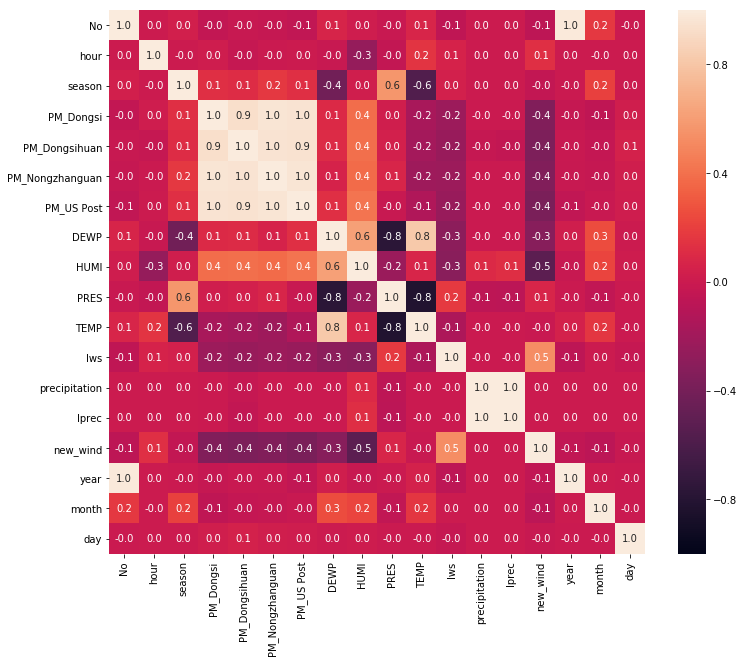

In [346]:
import seaborn as sns
corr = dataset_Beijing.corr()
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, vmin=-1, vmax=1,ax=ax, annot=True, fmt='.1f')

# Implementation 

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


def applyCV(name,estimator):
    # Construct the pipeline with a standard scaler and a small neural network
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append((name, estimator))
    model = Pipeline(estimators)

    # Split the data into features and target label

    features = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'new_wind', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'season_1', 'season_2', 'season_3', 'season_4', 'year']
    #features = ['HUMI', 'PRES', 'TEMP', 'Iws', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    X = dataset_Beijing_clean[features].values
    y = dataset_Beijing_clean['PM_US Post']

    # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
    # to train the model, and the prediction score will be computed on the remaining 20%.
    # This process is repeated five times such that the training sets in each "fold"
    # are mutually orthogonal.
    kfold = KFold(n_splits=5,  shuffle=True)

    print(estimators)

    print("**cross_val_score + KFold **")

    results_R2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    print('CV Scoring Result: r2 : mean=',np.mean(results_R2),'std=',np.std(results_R2))
    #print(results_R2) 
    print("**************")
    
    results_MAE = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    print('CV Scoring Result: MAE : mean=',np.mean(results_MAE),'std=',np.std(results_MAE))
    #print(results_MAE)  
    print("**************")

    results_MSE = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    print('CV Scoring Result: MSE : mean=',np.mean(results_MSE),'std=',np.std(results_MSE))
    #print(results_MSE) 
    
    print("***********************************")

    print("**cross_validate**")
    
    scores = cross_validate(model, X, y, scoring=('r2'), cv = 5)
    print('CV Scoring Result: r2 : mean=',np.mean(scores['test_score']))
    #print(scores)  
    print("**************")

    scores = cross_validate(model, X, y, scoring=('neg_mean_absolute_error'), cv = 5)
    print('CV Scoring Result: MAE : mean=',np.mean(scores['test_score']))
    #print(scores)  
    print("**************")

    scores = cross_validate(model, X, y, scoring=('neg_mean_squared_error'), cv = 5)
    print('CV Scoring Result: MSE : mean=',np.mean(scores['test_score']))
    #print(scores) 
    print("-----------------------------------------------")

    
applyCV("LR",LinearRegression())
print("*******************************************")
applyCV("RF",RandomForestRegressor(n_estimators = 96))
print("*******************************************")
applyCV("ANN",MLPRegressor(hidden_layer_sizes= (128, 256)))
print("*******************************************")
applyCV("SVR",SVR(kernel='rbf'))


[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]
**cross_val_score + KFold **
CV Scoring Result: r2 : mean= 0.42139133732123374 std= 0.009452061905465572
**************
CV Scoring Result: MAE : mean= -32.58298850630331 std= 0.36404102938226374
**************
CV Scoring Result: MSE : mean= -1749.0787098900612 std= 28.096697609786826
***********************************
**cross_validate**
CV Scoring Result: r2 : mean= 0.339717796316398
**************
CV Scoring Result: MAE : mean= -34.35836876069269
**************
CV Scoring Result: MSE : mean= -1917.7599253315486
-----------------------------------------------
*******************************************
[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impur

In [335]:
#Unneeded_Columns = ['precipitation', 'Iprec']
#dataset_Beijing_clean = dataset_Beijing_clean.drop(Unneeded_Columns, axis = 1)
display(dataset_Beijing_clean.head(n=1))


,year,day,PM_US Post,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,hour_sin,...,month_cos,season_1,season_2,season_3,season_4,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,cbwd_SW
26304,2013,1,31.0,-10.0,67.0,1018.0,-5.0,0.0,4.02,0.0,...,1.0,0,0,0,1,0,1,0,0,0


In [336]:
Un_needed_columns = ['PM_US Post', 'day']
# Split the data into features and target label
Features = dataset_Beijing_clean.drop(Un_needed_columns, axis = 1)
Target = dataset_Beijing_clean['PM_US Post']

# Saving feature names for later use
feature_list = list(Features.columns)

display(Features.head(n=2))
display(Target.head(n=2))

,year,DEWP,HUMI,PRES,TEMP,precipitation,new_wind,hour_sin,hour_cos,month_sin,month_cos,season_1,season_2,season_3,season_4,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,cbwd_SW
26304,2013,-10.0,67.0,1018.0,-5.0,0.0,4.02,0.000000,1.000000,0.0,1.0,0,0,0,1,0,1,0,0,0
26305,2013,-11.0,73.0,1017.0,-7.0,0.0,4.02,0.258819,0.965926,0.0,1.0,0,0,0,1,0,1,0,0,0


26304    31.0
26305    32.0
Name: PM_US Post, dtype: float64

In [337]:
#Shuffle and Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.20, random_state=0, shuffle=True)


In [338]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
Sc_X = StandardScaler()
X_train = Sc_X.fit_transform(X_train)
X_test = Sc_X.transform(X_test)

In [339]:
from sklearn.linear_model import LinearRegression

Linear_regression = LinearRegression()
start_Training_time = int(time() * 1000)
Linear_regression.fit(X_train, y_train)
end_Training_time = int(time() * 1000)

print( "Linear Regression: " )
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))


predict = Linear_regression.predict(X_test)

r2 = r2_score(y_test, predict)
MSE =  mean_squared_error(y_test,predict)

print('Testing: ')
print ('Testing r2_score: ', round(r2, 5))
print('Testing MSE_score: ', round(MSE,5))
MAE =  mean_absolute_error(y_test,predict)
print('MAE_score: ', round(MAE, 5))

# Calculate the absolute errors
errors = abs(predict - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Linear Regression: 
Training: 
Training took 8 ms
Testing: 
Testing r2_score:  0.44347
Testing MSE_score:  4903.67674
MAE_score:  49.54063
Mean Absolute Error: 49.54 degrees.
Accuracy: -23.31 %.


In [81]:
LR = LinearRegression()

# Feature Scaling
#Sc_X1 = StandardScaler()
#CorrelatedFeaturesScaled = Sc_X1.fit_transform(Features)

from sklearn.model_selection import cross_validate
scores = cross_validate(LR, Features, Target, scoring=('r2'), cv = 5)
print('CV Scoring Result: r2 : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(LR, Features, Target, scoring=('neg_mean_absolute_error'), cv = 5)
print('CV Scoring Result: MAE : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(LR, Features, Target, scoring=('neg_mean_squared_error'), cv = 5)
print('CV Scoring Result: MSE : mean=',np.mean(scores['test_score']))
print(scores) 

CV Scoring Result: r2 : mean= 0.3387106988059665
{'fit_time': array([0.00917792, 0.00906706, 0.01006794, 0.00928593, 0.00747609]), 'score_time': array([0.00102496, 0.00079203, 0.00118899, 0.00086808, 0.00074697]), 'test_score': array([0.28816409, 0.41287606, 0.29012866, 0.43806768, 0.26431701]), 'train_score': array([0.43279172, 0.41569321, 0.44405804, 0.41435907, 0.42237931])}
**************
CV Scoring Result: MAE : mean= -34.387072018757195
{'fit_time': array([0.01110673, 0.01003885, 0.01001191, 0.01002097, 0.00949979]), 'score_time': array([0.00071025, 0.00090003, 0.00093412, 0.00077105, 0.00065422]), 'test_score': array([-38.94252142, -33.65534361, -32.26122551, -34.03992329,
       -33.03634626]), 'train_score': array([-32.03182591, -32.05879952, -32.68665635, -32.09584054,
       -33.26350586])}
**************
CV Scoring Result: MSE : mean= -1920.539492677525
{'fit_time': array([0.01034594, 0.00862098, 0.00798321, 0.00873923, 0.00855994]), 'score_time': array([0.00077987, 0.00065

In [340]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 96)

start_Training_time = int(time() * 1000)
rf.fit(X_train, y_train) 
end_Training_time = int(time() * 1000)

print('Random Forest Regressor: ')
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))


start_Testing_time = int(time() * 1000)
predictions = rf.predict(X_test)
end_Testing_time = int(time() * 1000)

print('Testing: ')
print('Testing took {} ms'.format(end_Testing_time - start_Testing_time))
print('r2_score: ', round(r2_score(y_test,predictions),5))
MSE =  mean_squared_error(y_test,predictions)
print('MSE_score: ', round(MSE,5))
MAE =  mean_absolute_error(y_test,predictions)
print('MAE_score: ', round(MAE, 5))


# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Random Forest Regressor: 
Training: 
Training took 8911 ms
Testing: 
Testing took 224 ms
r2_score:  0.75602
MSE_score:  2149.74806
MAE_score:  29.07858
Mean Absolute Error: 29.08 degrees.
Accuracy: 43.05 %.


In [341]:
rf1 = RandomForestRegressor(n_estimators = 96)

# Feature Scaling
#Sc_X1 = StandardScaler()
#CorrelatedFeaturesScaled = Sc_X1.fit_transform(Features)


from sklearn.model_selection import cross_validate
scores = cross_validate(rf1, Features, Target, scoring=('r2'), cv = 5)
print('CV Scoring Result: r2 : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(rf1, Features, Target, scoring=('neg_mean_absolute_error'), cv = 5)
print('CV Scoring Result: MAE : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(rf1, Features, Target, scoring=('neg_mean_squared_error'), cv = 5)
print('CV Scoring Result: MSE : mean=',np.mean(scores['test_score']))
print(scores) 

CV Scoring Result: r2 : mean= 0.3573087032019326
{'fit_time': array([7.12572098, 7.56321597, 7.60502195, 9.26877999, 8.19162321]), 'score_time': array([0.08248019, 0.08208013, 0.10037088, 0.1391809 , 0.08149195]), 'test_score': array([0.38971715, 0.33682997, 0.31140218, 0.4253731 , 0.32322112]), 'train_score': array([0.96844955, 0.96930782, 0.96888003, 0.96883165, 0.96505101])}
**************
CV Scoring Result: MAE : mean= -50.014648913604425
{'fit_time': array([7.42002892, 7.08379698, 7.24449301, 7.11789584, 7.4953382 ]), 'score_time': array([0.08042717, 0.08387995, 0.08724213, 0.08626103, 0.08125901]), 'test_score': array([-56.15598149, -54.15686611, -36.90121197, -51.23713097,
       -51.62205403]), 'train_score': array([ -9.8046222 ,  -9.60417711, -10.62079082,  -9.89067502,
       -10.86109828])}
**************
CV Scoring Result: MSE : mean= -5503.740382471273
{'fit_time': array([7.25607967, 6.68307996, 6.83173299, 7.81816506, 8.47323895]), 'score_time': array([0.083776  , 0.07335

In [342]:
print('CV Scoring Result: r2 : mean=',np.mean(scores['test_score']))


CV Scoring Result: r2 : mean= -5503.740382471273


In [343]:
# Saving feature names for later use
feature_list = list(Features.columns)


# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: HUMI                 Importance: 0.21
Variable: month_cos            Importance: 0.19
Variable: PRES                 Importance: 0.13
Variable: DEWP                 Importance: 0.11
Variable: hour_sin             Importance: 0.06
Variable: TEMP                 Importance: 0.05
Variable: new_wind             Importance: 0.05
Variable: year                 Importance: 0.04
Variable: hour_cos             Importance: 0.04
Variable: month_sin            Importance: 0.04
Variable: cbwd_NW              Importance: 0.03
Variable: precipitation        Importance: 0.01
Variable: season_1             Importance: 0.01
Variable: season_3             Importance: 0.01
Variable: season_4             Importance: 0.01
Variable: cbwd_NE              Importance: 0.01
Variable: cbwd_SE              Importance: 0.01
Variable: cbwd_cv              Importance: 0.01
Variable: season_2             Importance: 0.0
Variable: cbwd_SW              Importance: 0.0


In [344]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

mlp = MLPRegressor(hidden_layer_sizes= (128, 256))
start_Training_time = int(time() * 1000)
mlp.fit(X_train,y_train)
end_Training_time = int(time() * 1000)

print('Neural Network / MLPRegressor: ')
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))

predictions = mlp.predict(X_test)

print('Testing: ')
r2 = r2_score(y_test,predictions)
print('r2_score: ', r2)
MSE =  mean_squared_error(y_test,predictions)
print('MSE_score: ', MSE)
MAE =  mean_absolute_error(y_test,predictions)
print('MAE_score: ', MAE)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Neural Network / MLPRegressor: 
Training: 
Training took 28459 ms
Testing: 
r2_score:  0.6759609689124979
MSE_score:  2855.160714513309
MAE_score:  34.86040919381205
Mean Absolute Error: 34.86 degrees.
Accuracy: 36.72 %.


In [345]:
mlp = MLPRegressor(hidden_layer_sizes= (128, 256))

# Feature Scaling
#Sc_X1 = StandardScaler()
#CorrelatedFeaturesScaled = Sc_X1.fit_transform(Features)


from sklearn.model_selection import cross_validate
scores = cross_validate(mlp, Features, Target, scoring=('r2'), cv = 5)
print('CV Scoring Result: r2 : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(mlp, Features, Target, scoring=('neg_mean_absolute_error'), cv = 5)
print('CV Scoring Result: MAE : mean=',np.mean(scores['test_score']))
print(scores)  
print("**************")

scores = cross_validate(mlp, Features, Target, scoring=('neg_mean_squared_error'), cv = 5)
print('CV Scoring Result: MSE : mean=',np.mean(scores['test_score']))
print(scores) 

CV Scoring Result: r2 : mean= 0.32907201849208445
{'fit_time': array([5.97638607, 3.37155604, 5.23277903, 4.30535388, 4.52636075]), 'score_time': array([0.0190351 , 0.01708388, 0.0237999 , 0.01712704, 0.0199101 ]), 'test_score': array([0.37825289, 0.33581869, 0.14969234, 0.40964236, 0.37195381]), 'train_score': array([0.36878136, 0.42809582, 0.42561679, 0.42942102, 0.40854754])}
**************
CV Scoring Result: MAE : mean= -50.58838204930847
{'fit_time': array([5.15710521, 5.31686497, 6.36405206, 5.46341109, 4.32580519]), 'score_time': array([0.01982689, 0.02350116, 0.03463006, 0.01842499, 0.01704502]), 'test_score': array([-53.41810598, -53.20121608, -42.11632279, -52.6517969 ,
       -51.5544685 ]), 'train_score': array([-47.768908  , -53.06823359, -51.23850911, -48.89589407,
       -50.63270411])}
**************
CV Scoring Result: MSE : mean= -5620.836238272661
{'fit_time': array([ 6.11319804,  6.44815397,  5.192523  ,  4.52183867, 11.4122324 ]), 'score_time': array([0.02356505, 0.

In [346]:
from sklearn.svm import SVR

clf = SVR(kernel='rbf')
start_Training_time = int(time() * 1000)
clf.fit(X_train, y_train) 
end_Training_time = int(time() * 1000)

print('Support Vector Regression: ')
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))

start_Testing_time = int(time() * 1000)
predictions = clf.predict(X_test)
end_Testing_time = int(time() * 1000)

print('Testing: ')
print('Testing took {} ms'.format(end_Testing_time - start_Testing_time))
print('r2_score: ', round(r2_score(y_test,predictions),5))
MSE =  mean_squared_error(y_test,predictions)
print('MSE_score: ', round(MSE,5))
MAE =  mean_absolute_error(y_test,predictions)
print('MAE_score: ', MAE)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Support Vector Regression: 
Training: 
Training took 19332 ms
Testing: 
Testing took 3633 ms
r2_score:  0.39146
MSE_score:  5361.93926
MAE_score:  44.85687963318366
Mean Absolute Error: 44.86 degrees.
Accuracy: 26.93 %.


In [347]:
from sklearn.svm import SVR

clf = SVR(kernel='rbf', C = 707, epsilon = 4, gamma = 0.001 )
start_Training_time = int(time() * 1000)
clf.fit(X_train, y_train) 
end_Training_time = int(time() * 1000)

print('Support Vector Regression: ')
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))

start_Testing_time = int(time() * 1000)
predictions = clf.predict(X_test)
end_Testing_time = int(time() * 1000)

print('Testing: ')
print('Testing took {} ms'.format(end_Testing_time - start_Testing_time))
print('r2_score: ', round(r2_score(y_test,predictions),5))
MSE =  mean_squared_error(y_test,predictions)
print('MSE_score: ', round(MSE,5))
MAE =  mean_absolute_error(y_test,predictions)
print('MAE_score: ', MAE)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Support Vector Regression: 
Training: 
Training took 21751 ms
Testing: 
Testing took 3532 ms
r2_score:  0.45664
MSE_score:  4787.6579
MAE_score:  43.90982556549348
Mean Absolute Error: 43.91 degrees.
Accuracy: 20.08 %.


In [348]:
from sklearn.svm import SVR

clf = SVR(kernel='linear')
start_Training_time = int(time() * 1000)
clf.fit(X_train, y_train) 
end_Training_time = int(time() * 1000)

print('Support Vector Regression: ')
print('Training: ')
print('Training took {} ms'.format(end_Training_time - start_Training_time))

start_Testing_time = int(time() * 1000)
predictions = clf.predict(X_test)
end_Testing_time = int(time() * 1000)

print('Testing: ')
print('Testing took {} ms'.format(end_Testing_time - start_Testing_time))
print('r2_score: ', round(r2_score(y_test,predictions),5))
MSE =  mean_squared_error(y_test,predictions)
print('MSE_score: ', round(MSE,5))
MAE =  mean_absolute_error(y_test,predictions)
print('MAE_score: ', MAE)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Support Vector Regression: 
Training: 
Training took 15450 ms
Testing: 
Testing took 1816 ms
r2_score:  0.36971
MSE_score:  5553.58035
MAE_score:  47.67999221472492
Mean Absolute Error: 47.68 degrees.
Accuracy: 6.54 %.
